GANs can be extended to conditional models if the generator and the discriminator are conditioned by a supplementary condition. In this notebook you will find an implementation of the paper of Mirza & Osindero : "Conditional Generative Adversarial Nets" 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.utils
from torchvision.utils import make_grid

import torchvision.datasets

import matplotlib.pyplot as plt 
plt.rcParams["figure.figsize"] = (10,6)

from tqdm import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
batch_size = 128 # Images per batch

# Resize to 32x32 for easier upsampling/downsampling
mytransform = transforms.Compose([transforms.Resize(32),
                                  transforms.ToTensor(),
                                 transforms.Normalize((.5), (.5))]) # normalize between [-1, 1] with tanh activation

mnist_train = torchvision.datasets.MNIST(root='.', download=True, transform=mytransform)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [9]:
dataloader = DataLoader(dataset=mnist_train, 
                         batch_size=batch_size,
                         shuffle=True)    

In [3]:
def get_upscaling_block(channels_in, channels_out, kernel, stride, padding, last_layer=False):
    '''
    Each transpose conv will be followed by BatchNorm and ReLU, 
    except the last block (which is only followed by tanh)
    '''
    if last_layer:
        model = nn.Sequential(
          nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.Tanh(),
        )
    else:
        model = nn.Sequential(
          nn.ConvTranspose2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.BatchNorm2d(channels_out),
          nn.ReLU(),
        )
    return model

def get_downscaling_block(channels_in, channels_out, kernel, stride, padding, use_batch_norm=True, is_last=False):
    
    if is_last:
        model = nn.Sequential(
          nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.Sigmoid(),
        )
    
    elif not use_batch_norm:
        model = nn.Sequential(
          nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.LeakyReLU(0.2),
        )
    
    else:
        model = nn.Sequential(
          nn.Conv2d(channels_in, channels_out, kernel_size=kernel, stride=stride, padding=padding),
          nn.BatchNorm2d(channels_out),
          nn.LeakyReLU(0.2),
        )
    return model


In [7]:
# GENERATOR
class ConditionalGenerator(nn.Module):
    def __init__(self, nz, nc, ngf, nchannels=1):
        super().__init__()
        
        self.upscaling_z = get_upscaling_block(nz, ngf*8, 4, 1, 0)
        self.upscaling_c = get_upscaling_block(nc, ngf*8, 4, 1, 0)

        self.rest_model = nn.Sequential(
            get_upscaling_block(ngf*8*2, ngf*8, 4, 2, 1),
            get_upscaling_block(ngf*8, ngf*4, 4, 2, 1),
            get_upscaling_block(ngf*4, nchannels, 4, 2, 1, last_layer=True),
        )
        
        
    def forward(self, x, y):
        x = x.unsqueeze(2).unsqueeze(2)
        y = y.unsqueeze(2).unsqueeze(2)

        x2 = self.upscaling_z(x)
        y2 = self.upscaling_c(y)

        x =  torch.cat((x2, y2), dim=1)
        
        return self.rest_model(x)

In [4]:
# Discriminator

class ConditionalDiscriminator(nn.Module):
    def __init__(self, ndf, nc, nchannels=1):
        super().__init__()
        self.downscale_x = get_downscaling_block(nchannels, ndf*2, 4, 2, 1, use_batch_norm=False)
        self.downscale_y = get_downscaling_block(nc, ndf*2, 4, 2, 1, use_batch_norm=False)
        
        self.rest = nn.Sequential(
            get_downscaling_block(ndf*2*2, ndf*8, 4, 2, 1),
            get_downscaling_block(ndf*8, ndf*16, 4, 2, 1),
            get_downscaling_block(ndf*16, nchannels, 4, 1, 0, is_last=True),
        )
        
    def forward(self, x, y):
        y = y.unsqueeze(2).unsqueeze(2).expand(y.shape[0], 10, 32, 32)
        x2 = self.downscale_x(x)
        y2 = self.downscale_y(y)
        x =  torch.cat((x2, y2), dim=1)
        
        return self.rest(x).squeeze(1).squeeze(1) # remove spatial dimensions

In [5]:
def sample_z(batch_size, nz):
    return torch.randn(batch_size, nz, device=device)

# this is for the real ground-truth label
def get_labels_one(batch_size):
    r = torch.ones(batch_size, 1)
    return r.to(device)

# this is for the generated ground-truth label
def get_labels_zero(batch_size):
    r = torch.zeros(batch_size, 1) 
    return r.to(device)


# To initialize the weights of a GAN, the DCGAN paper found that best results are obtained
# with Gaussian initialization with mean=0; std=0.02
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)
        

# for visualization
to_pil = transforms.ToPILImage()
renorm = transforms.Normalize((-1.), (2.))

In [8]:
nz = 100
ndf = 32
ngf = 32
nchannels= 1 
lr_d = 0.0002
lr_g = 0.0005
beta1= 0.5
display_freq = 200

nc= 10

netD = ConditionalDiscriminator(ndf, nc, nchannels=1).to(device)
netG = ConditionalGenerator(nz, nc, ngf).to(device)
        
netG.apply(weights_init)
netD.apply(weights_init)

g_opt = torch.optim.Adam(netG.parameters(), lr=lr_g, betas=(beta1, 0.999))
d_opt = torch.optim.Adam(netD.parameters(), lr=lr_d, betas=(beta1, 0.999))



In [10]:
criterion = nn.BCELoss()

it: 0; g_loss: 6.419593811035156; d_loss: 1.8342334032058716; avg_real_score: 0.6786877512931824; avg_fake_score: 0.006682875566184521: : 0it [00:00, ?it/s]

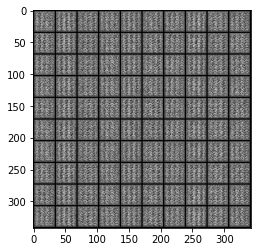

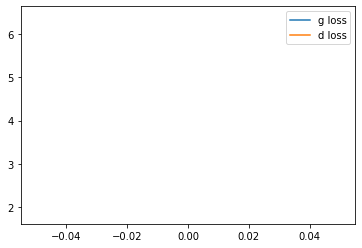

it: 200; g_loss: 2.2914962768554688; d_loss: 1.814665675163269; avg_real_score: 0.5335397720336914; avg_fake_score: 0.11392820626497269: : 200it [01:25,  2.37it/s]

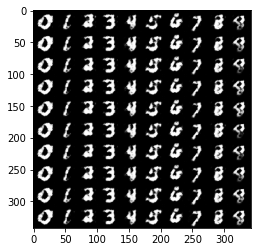

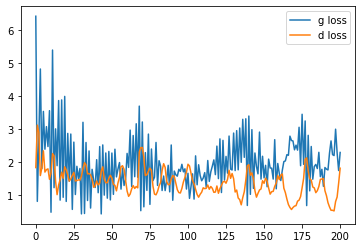

it: 400; g_loss: 1.3640878200531006; d_loss: 1.1114170551300049; avg_real_score: 0.5362133979797363; avg_fake_score: 0.28370290994644165: : 400it [02:50,  2.37it/s]

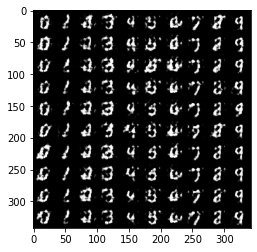

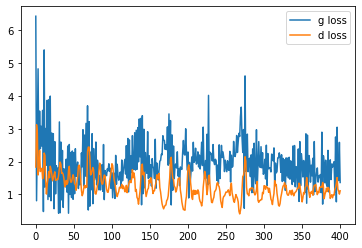

it: 468; g_loss: 1.0545871257781982; d_loss: 1.152140736579895; avg_real_score: 0.4741620421409607; avg_fake_score: 0.383050799369812: : 469it [03:19,  2.35it/s]
it: 469; g_loss: 2.0778894424438477; d_loss: 0.9649524092674255; avg_real_score: 0.768008291721344; avg_fake_score: 0.14655902981758118: : 0it [00:00, ?it/s]

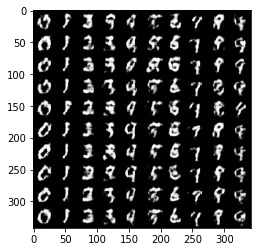

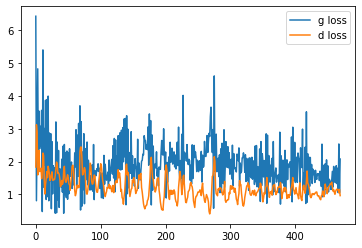

it: 669; g_loss: 1.3579964637756348; d_loss: 1.360643744468689; avg_real_score: 0.5314693450927734; avg_fake_score: 0.287861704826355: : 200it [01:25,  2.35it/s]   

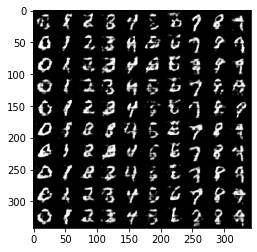

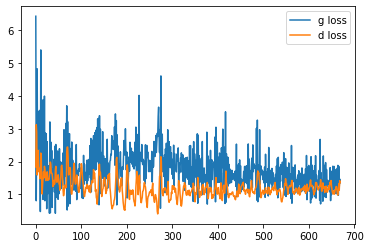

it: 869; g_loss: 1.8035526275634766; d_loss: 1.2636469602584839; avg_real_score: 0.6736437678337097; avg_fake_score: 0.18865787982940674: : 400it [02:51,  2.35it/s]

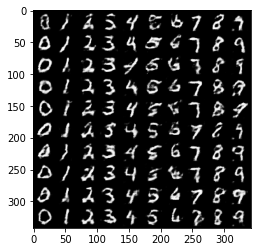

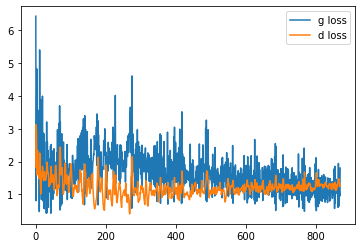

it: 937; g_loss: 1.2115839719772339; d_loss: 1.289705514907837; avg_real_score: 0.5770303010940552; avg_fake_score: 0.3164679706096649: : 469it [03:20,  2.34it/s]
it: 938; g_loss: 0.8068417310714722; d_loss: 1.3853158950805664; avg_real_score: 0.47879403829574585; avg_fake_score: 0.4689200818538666: : 0it [00:00, ?it/s]

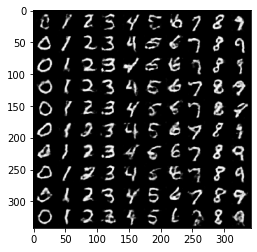

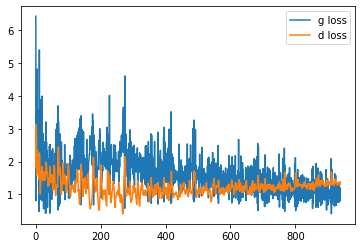

it: 1138; g_loss: 0.7127766013145447; d_loss: 1.3355381488800049; avg_real_score: 0.4531690776348114; avg_fake_score: 0.5076826810836792: : 200it [01:26,  2.35it/s]

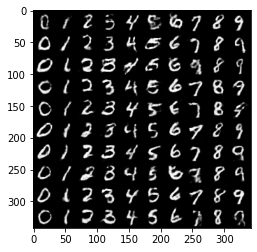

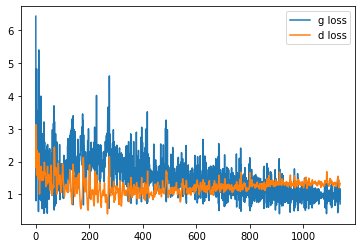

it: 1338; g_loss: 0.9227086305618286; d_loss: 1.2913055419921875; avg_real_score: 0.5433298945426941; avg_fake_score: 0.40852928161621094: : 400it [02:52,  2.35it/s]

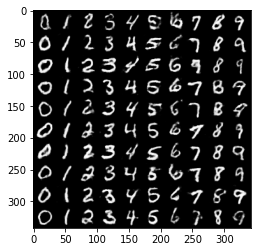

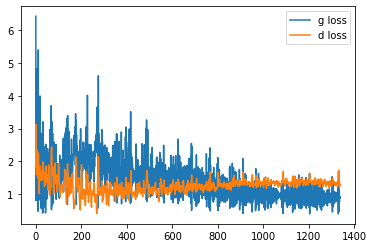

it: 1406; g_loss: 1.2532272338867188; d_loss: 1.2525177001953125; avg_real_score: 0.5825225114822388; avg_fake_score: 0.30209678411483765: : 469it [03:21,  2.33it/s]
it: 1407; g_loss: 0.590060830116272; d_loss: 1.4270344972610474; avg_real_score: 0.4130544066429138; avg_fake_score: 0.5654453039169312: : 0it [00:00, ?it/s]

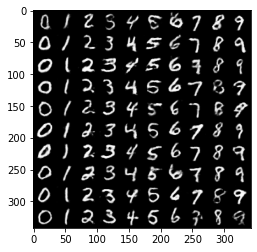

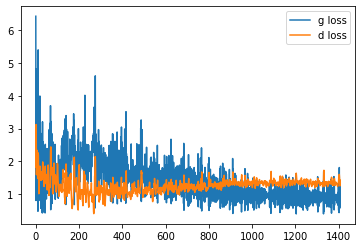

it: 1607; g_loss: 1.554229497909546; d_loss: 1.3847987651824951; avg_real_score: 0.683400571346283; avg_fake_score: 0.2255343347787857: : 200it [01:26,  2.34it/s]  

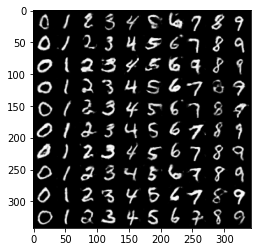

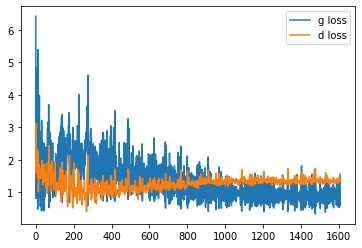

it: 1807; g_loss: 0.7870055437088013; d_loss: 1.3522871732711792; avg_real_score: 0.4535726308822632; avg_fake_score: 0.4642946720123291: : 400it [02:52,  2.34it/s]

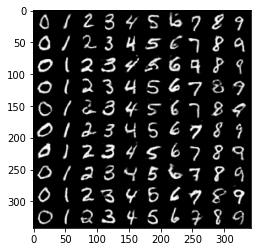

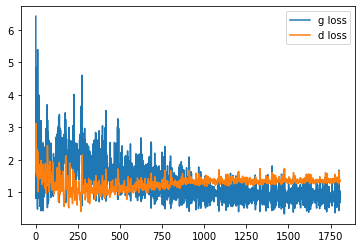

it: 1875; g_loss: 0.858874499797821; d_loss: 1.2611229419708252; avg_real_score: 0.49561163783073425; avg_fake_score: 0.43218982219696045: : 469it [03:22,  2.32it/s]
it: 1876; g_loss: 0.979314923286438; d_loss: 1.3292453289031982; avg_real_score: 0.5635921955108643; avg_fake_score: 0.3878241181373596: : 0it [00:00, ?it/s]

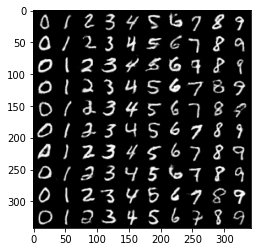

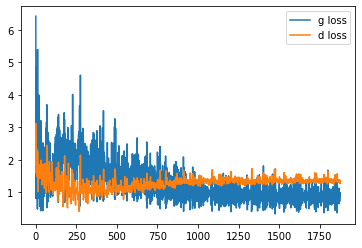

it: 2076; g_loss: 1.2590737342834473; d_loss: 1.4513602256774902; avg_real_score: 0.688980221748352; avg_fake_score: 0.2950933277606964: : 200it [01:26,  2.33it/s] 

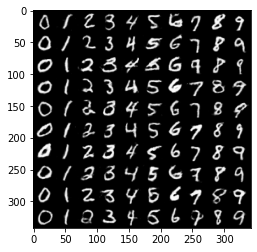

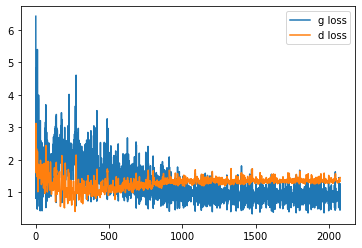

it: 2276; g_loss: 0.9926348924636841; d_loss: 1.2957050800323486; avg_real_score: 0.571980893611908; avg_fake_score: 0.38110387325286865: : 400it [02:53,  2.32it/s]

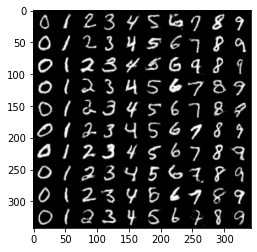

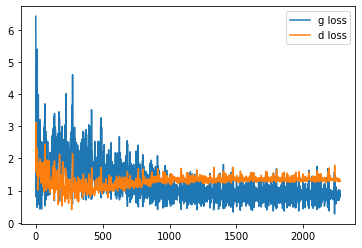

it: 2344; g_loss: 0.8661613464355469; d_loss: 1.2920432090759277; avg_real_score: 0.5007890462875366; avg_fake_score: 0.4287949800491333: : 469it [03:23,  2.31it/s]


In [11]:
nb_epochs = 5

g_losses = []
d_losses = []

j = 0

z_test = sample_z(100, nz)


for epoch in range(nb_epochs):
    
    pbar = tqdm(enumerate(dataloader))
    for i, batch in pbar:
        im, labels = batch 
        im = im.to(device)
        
        
        y = F.one_hot(labels).float().to(device)
        
        cur_batch_size = im.shape[0]  
        
        # 1. sample a z vector 
        z = torch.randn(cur_batch_size, nz).to(device)

        # 2. Generate a fake image
        fake_image = netG(z, y)
       
        # 3. Classify real image with D
        yhat_real = netD(im, y)

        # 4. Classify fake image with D
        yhat_fake = netD(fake_image.detach(), y)
        
        ###
        ### Discriminator
        ###
        real_labels = torch.ones((cur_batch_size, 1)).to(device)
        fake_labels = torch.zeros((cur_batch_size, 1)).to(device)
        #labels = labels.reshape(-1, 1).float()
        
        d_loss = criterion(yhat_real, real_labels) 
        d_loss = d_loss + criterion(yhat_fake, fake_labels)
        d_opt.zero_grad()
        d_loss.backward(retain_graph=True) 
        d_opt.step()
        
        
        ###
        ### Generator
        ###
        
        yhat_fake = netD(fake_image, y)
        g_loss = criterion(yhat_fake, real_labels)
        g_opt.zero_grad()
        g_loss.backward()
        g_opt.step()
        
        
        # Save Metrics
        
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
        avg_real_score = yhat_real.mean().item()
        avg_fake_score = yhat_fake.mean().item()

        pbar.set_description(f"it: {j}; g_loss: {g_loss}; d_loss: {d_loss}; avg_real_score: {avg_real_score}; avg_fake_score: {avg_fake_score}")
        
        if i % display_freq == 0:
            labels = torch.arange(0, 10).expand(size=(10, 10)).flatten().to(device)
            y = F.one_hot(labels).float().to(device)
            fake_im = netG(z_test, y)
            
            un_norm = renorm(fake_im) # for visualization
            
            grid = torchvision.utils.make_grid(un_norm, nrow=10)
            pil_grid = to_pil(grid)  
            
            plt.imshow(pil_grid)
            plt.show()
            
            
            plt.plot(range(len(g_losses)), g_losses, label='g loss')
            plt.plot(range(len(g_losses)), d_losses, label='d loss')
            
            plt.legend()
            plt.show()
            
        j += 1
            